In [59]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
# This code segment is not used in the final pipeline since training was done using a different standardization method.
# If all images were standardized in the training dataset using this standardization techinique, this portion can be included into the pipeline.

# Blur image, Threshold

In [60]:
def mean_threshold(img, display=True):
    mean = np.mean(img)

    img[img >= mean] = 255
    img[img < mean] = 0

    if display:
        plt.figure(figsize = [10, 10])
        plt.axis('off')
        plt.imshow(img, cmap="gray")

    return img

In [61]:
def threshold(img, threshold=0.5):
    img[img >= threshold] = 1
    img[img < threshold] = 0

    return img
    

In [62]:
def clean_img(img_path):
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for _ in range(5):
        img = cv2.blur(img, (10, 10))
        mean_threshold(img)

    return img 

In [63]:
# img = clean_img('../dataset/handwritten_operators/plus/plus 2.png')
# plt.axis('off')
# plt.imshow(img, cmap='gray')

In [64]:
def adaptive_clean(img_path, load=True, mode='otsu'):
    # Load image
    if load:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    else:
        img = img_path

    # Convert to grayscale and apply Otsu's binarization for noise reduction
    # https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    img = cv2.GaussianBlur(img,(5,5),0)
    if mode == 'otsu':
        _, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # or you can use gaussian/mean adaptive thresholding
    elif mode == 'mean':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    elif mode == 'gaussian':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

    img = 255 - img

    # Can also apply some morphological transformations
    # https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    kernel = np.ones((3, 3), dtype=np.uint8) # or you can use cv2.getStructuringElement()
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img


(135, 155)


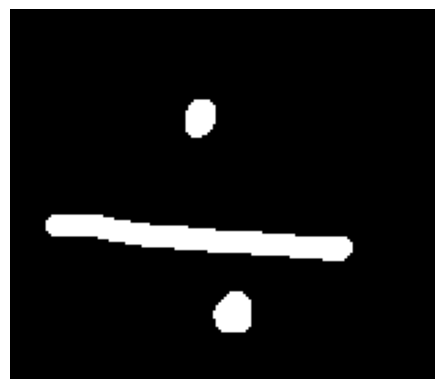

In [65]:
img = adaptive_clean('./standardization_symbols/dataset1_div_20.jpg')
print(img.shape)
plt.axis('off')
plt.imshow(img, cmap='gray')

# Center the Image

In [66]:
# img = cv2.imread('./Four_full (16).jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# h, w = img.shape[:2]
# new = np.zeros((h, w, 3), dtype=np.uint8)
# new[:, :, :] = img[:, :, :]

# plt.axis('off')
# plt.imshow(new)

In [67]:
from math import ceil
# Center and square an image
def center_img(img):
    # Assuming the image is clean, choose the bounding box for the symbol
    bx, by, bw, bh = cv2.boundingRect(img)
    print(bx, by, bw, bh)

    dim = max(bw, bh) * 1.05 # width of canvas 
    x_tl, y_tl = dim / 1.05 / 2 - bw / 2 + dim / 1.05 * .025, dim / 1.05 / 2 - bh / 2 + dim / 1.05 * .025 # top left corner

    dim = ceil(dim)
    x_tl, y_tl = int(x_tl), int(y_tl)
    centered = np.zeros((dim, dim))

    for y in range(by, by + bh):
        for x in range(bx, bx + bw):
            centered[y - by + y_tl][x - bx + x_tl] = img[y][x]
            
    return centered

13 33 112 85


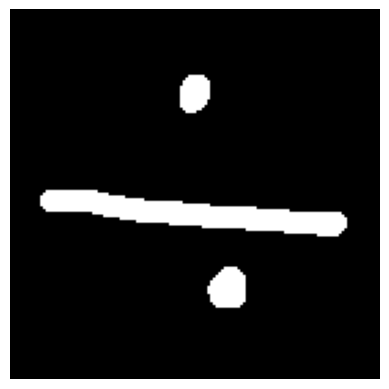

In [68]:
centered = center_img(img)
plt.axis('off')
plt.imshow(centered, cmap='gray')

# Rescale the Image

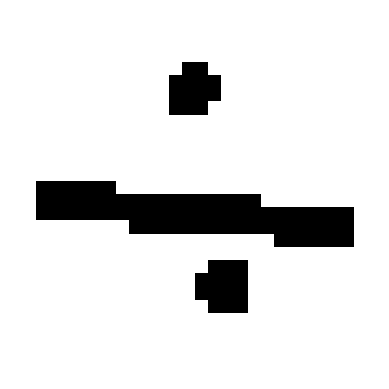

In [69]:
# need similar padding for all images
# same center, scale, thickness

def resize_img(img, dim=28):

    resize = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_AREA)
    # resize = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_NEAREST)
    # resize = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_CUBIC)

    resize[resize > 0] = 100
    resize[resize < 100] = 255
    resize[resize == 100] = 0

    return resize

resized = resize_img(centered)
plt.axis('off')
plt.imshow(resized, cmap='gray')

# Removing shadows, hist-eq

In [70]:
def remove_shadows(img):
    # Generate the shadow of the image
    # Create a 9x9 kernel, can also use np.ones()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

    # Some morphology operators
    # https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html 
    # https://docs.opencv.org/3.4/d3/dbe/tutorial_opening_closing_hats.html
    shadow = cv2.dilate(img, kernel) # Make the background bleed into the text to cover it up

    # Filtering
    # https://docs.opencv.org/3.4/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html
    shadow = cv2.medianBlur(shadow, 21) # Use a median filter to cover up the text entirely (there may still be particles in the text), now we have an image with only the shadow

    res = 255 - cv2.absdiff(img, shadow) # Remove the shadow from the original image
    return res

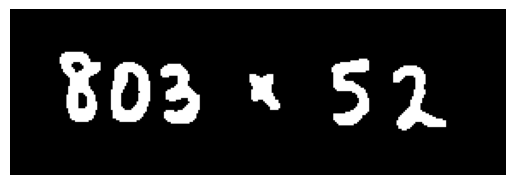

In [71]:
# from cv2 import dnn_superres
img = cv2.imread('../equation-dataset/dark-background/6.png', cv2.IMREAD_GRAYSCALE).astype(np.uint8)
img = remove_shadows(img)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
img = cv2.erode(img, kernel, iterations=1)
# upsampling may improve results
# https://docs.opencv.org/4.x/d5/d29/tutorial_dnn_superres_upscale_image_single.html
# sr = dnn_superres.DnnSuperResImpl_create()
# sr.readModel("./FSRCNN_x2.pb")
# sr.setModel("fsrcnn", 2)
# img = sr.upsample(img)
# CLAHE
# https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# clahe = cv2.createCLAHE(clipLimit=25.0, tileGridSize=(14,7))
# img = clahe.apply(img)
# Clean
img = adaptive_clean(img, load=False)

plt.axis('off')
plt.imshow(img, cmap='gray')

# All together

In [72]:
def standardize(img_path):
    img = adaptive_clean(img_path)
    img = center_img(img)
    img = resize_img(img)
    return img

In [73]:
import os
print(os.listdir('../test_data_01'))

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']


In [74]:
print(np.max(img))

255


148 146 59 95
154 152 64 83
155 152 62 83
154 152 61 83
28 27 169 334
36 35 249 318
31 30 152 328
31 30 215 328
33 32 275 324
34 33 218 322
33 32 245 324
33 40 42 81


962 1047 1196 1277


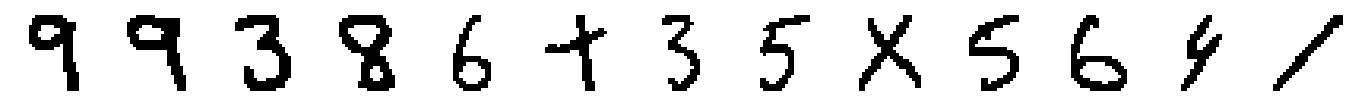

In [75]:
fig = plt.figure(figsize=(20, 15))
i = 0
for image in os.listdir('./standardization_symbols/')[1:]:
    resized = standardize(os.path.join('./standardization_symbols/', image))
    ax = fig.add_subplot(1, 15, i+1)
    i+=1
    ax.axis('off')
    plt.imshow(resized, cmap='gray')
    plt.imsave(image, resized, cmap='gray')
plt.show()